In [1]:
import pyautogui as ag
import time 
import requests
import glob
import os.path
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from IPython.display import display, Image, clear_output
from collections import OrderedDict
from datetime import datetime, date
#import esbl 
%matplotlib widget
ip = '169.254.29.57'

In [2]:
#set temperature 
requests.get('http://'+str(ip)+':5000/temp/37').text

'success?'

In [3]:
# Button positions in Tecan Spark 
pos_edit_worklist_plate_in = (710,60)
pos_edit_worklist_start = (480,60)
pos_edit_worklist_end = (2420,1330)
pos_edit_worklist_pause = (2320,1330)
pos_edit_worklist_stop = (2460,1330)
pos_edit_worklist_plate_out_exp = (330,1330)

path_tecan_results = "C:\\Users\\Public\\Documents\\Tecan\\SparkControl\\Export\\xlsx\\" 

### Opentron labware : 
- temperature module 
- container with media on the temperature module -> deepwell 
- trail -> tecan plate holder 
- tips -> 5 racks -> hard to put more because risk of contamination or not enough space because of peltier 
- pipettes single channel / multi channel 300 ul 

### Overnight 
- glucose:  0.369
- glucose + caa: 0.765

### Preculture 
- started at 9:45 at OD of  
   - glucose 0.053
   - glucose + caa 0.063
- at 3-4 hours in falcon (50 ml) OD of 
    - glucose 0.267
    - glucose + caa 0.807
    
for experiment diluted to 0.05 then another 100 times 

### Media: 
- 1 g/l glucose 
- 1 g/l glucose + 0.2 % casamino acids 

### Layout: 

- D2 -- media without bacteria ( will be substracted from all OD measurements) 
- Line E, G glucose 
- Line F, H glucose + casamino acids 

### Dilutions with: 
- fresh media 
- media + 0.25 g/l ctx
- media + 0.5 g/l ctx 
- media + 1 g/l ctx 


### Plan: 
- set temperature for the media to 37 degrees 

- launch 10 min program on tecan 
- get results ( - background ) 
- if OD  is higher than target: 
    plate out;
    transfer 100ul of media (+ mixing) 
    transfer 100 ul (- evaporation for the first step) from trail to trash 
    plate in 
- launch 10 min program 



In [4]:
def get_tecan_results_file(): 
    file_type = '*.xlsx'
    files = glob.glob(path_tecan_results + file_type)
    last_file = max(files, key=os.path.getctime)
    return last_file

def read_excel(name): 
    try: 
        data = np.array(pd.read_excel(name, engine='openpyxl'))
        start = np.where(data[:, 0] == 'Cycle Nr.')[0][0] + 1
        stop = np.where(data[:, 0] == 'End Time')[0][0] - 1
#         stop = np.where(data[:, 0] == 'AutoFl')[0][0] - 1
        times = np.array(data[start:stop, 1], dtype=np.float)
        plates = np.array(data[start:stop, 3:], dtype=np.float)
        return times / 3600, plates
    except: 
        return np.array([]), np.array([])

def launch_program(): 
    ag.click(*pos_edit_worklist_start)
    time.sleep(10 * 60 + 10) 
    ag.click(*pos_edit_worklist_end)

def evaporation(volume, time): 
    return 200*0.05*time #volume * 0.05 * time

In [5]:
def remove_background(ods, od0=0.05/100, avgrange=None,
                      factor=1.5, peaks=True):
    if not avgrange:
        avgrange = range(3, 8)
    shifted = ods - ods[avgrange].mean(axis=0) + od0 * factor
    return shifted
    

##  Test trail position 

In [6]:
# requests.get('http://'+str(ip)+':5000/tips/drop').text
requests.get('http://'+str(ip)+':5000/tips/pick_up').text
ag.click(*pos_edit_worklist_plate_in)
time.sleep(10)
requests.get('http://'+str(ip)+':5000/move_to/trail/1').text

'done gotcha'

In [15]:
# requests.get('http://'+str(ip)+':5000/tips/return').text
# requests.get('http://'+str(ip)+':5000/home').text

'success?'

In [7]:
# requests.get('http://'+str(ip)+':5000/tips/return').text

In [7]:
requests.get('http://'+str(ip)+':5000/tips/drop').text
requests.get('http://'+str(ip)+':5000/home').text
ag.click(*pos_edit_worklist_plate_in)
time.sleep(10)

## Initialise experiment 

In [8]:
wells = np.array([L + str(i) for L in "ABCDEFGH" for i in range(1, 12)])

empty_well_index = 12*3+1 #np.where(wells == 'D2')[0][0]
line1 = np.array([12*4 + x for x in range (1, 9)]) # Line E -- glucose 
line2 = np.array([12*5 + x for x in range (1, 9)]) # Line F -- glucose + caa 
line3 = np.array([12*6 + x for x in range (1, 9)]) # Line E -- glucose 
line4 = np.array([12*7 + x for x in range (1, 9)]) # Line F -- glucose + caa 

lines = np.array([line1, line2, line3, line4]) 

OD_target_high = [0.1, 0.1, 0.05, 0.05]  
OD0 = 5*10**(-4) # starting point 

OD_line1 =  np.full((1, 8), OD0)
OD_line2 =  np.full((1, 8), OD0)
OD_line3 =  np.full((1, 8), OD0)
OD_line4 =  np.full((1, 8), OD0)

OD_data_all_line_1 = np.array([])
OD_data_all_line_2 = np.array([])
OD_data_all_line_3 = np.array([])
OD_data_all_line_4 = np.array([])

last_OD_line1 =  np.full((1, 8), OD0)
last_OD_line2 =  np.full((1, 8), OD0)
last_OD_line3 =  np.full((1, 8), OD0)
last_OD_line4 =  np.full((1, 8), OD0)


times_all = np.array([])
start_time = 0  #human starting point 

t0 = time.time() # starting point 

# Layout: 

media = np.array(['1 g/l glucose', '1 g/l glucose + 0.2 % casamino acids', '1 g/l glucose', '1 g/l glucose + 0.2 % casamino acids'])
antibiotic = np.array(['0', '0.25 mg/l', '0.5 mg/l', '1 mg/l'])
last_dilution_time =  np.zeros(media.size)
print(last_dilution_time)
volume = 100
count_dilutions = np.zeros(media.size)
print(count_dilutions)
print(np.sum(count_dilutions))
dilution_times = [[], [], [], []] 
strain = 'NILS18'
volumes_out = [[], [], [], []]

 
max_dilutions_well = 15
max_dilutions = max_dilutions_well 

max_dilutions_tips = 5 * 12 - 1


date = str(datetime.now()).split(' ')[0]
print(date)

[0. 0. 0. 0.]
[0. 0. 0. 0.]
0.0
2022-04-08


started at 13:54

## Run experiment

Launching tecan
got OD
0.0 0.0005499999999999949 -7.500000000000215e-05 0.00034999999999999615
done step  0
Launching tecan
got OD
0.0 0.0005499999999999949 -7.500000000000215e-05 0.00034999999999999615
done step  1
Launching tecan
got OD
0.00027499999999999747 0.0014749999999999971 0.0002249999999999995 0.0016000000000000007
done step  2
Launching tecan
got OD
0.0006499999999999978 0.0027249999999999983 0.0009499999999999995 0.0035749999999999983
done step  3
Launching tecan
got OD
0.0009749999999999967 0.0036249999999999963 0.0011249999999999975 0.004725
done step  4
Launching tecan
got OD
0.0005499999999999949 0.0049999999999999975 0.0007749999999999944 0.004774999999999998
done step  5
Launching tecan
got OD
0.0006999999999999992 0.0059000000000000025 0.0010249999999999981 0.005075000000000003
done step  6
Launching tecan
got OD
0.0007750000000000049 0.0063500000000000015 0.0011750000000000024 0.0057249999999999975
done step  7
Launching tecan
got OD
0.0010500000000000023 0.0073000

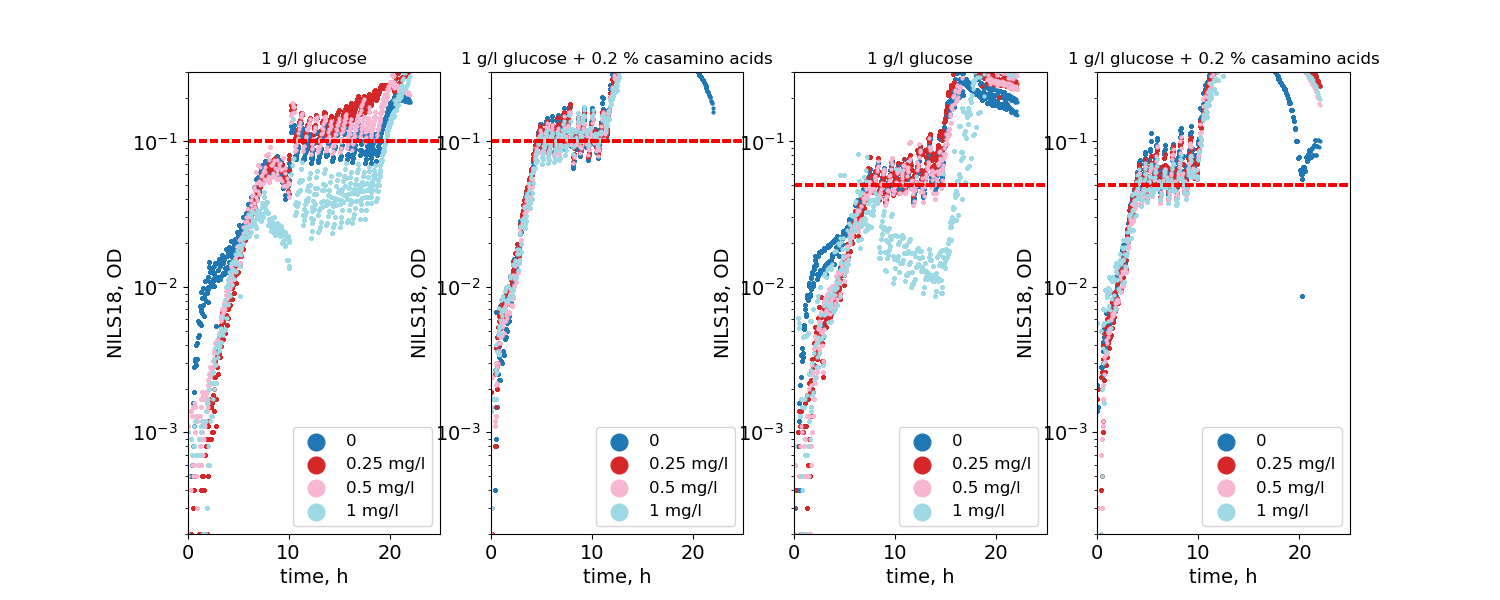

In [9]:
f3, ax3 = plt.subplots(1, 4, sharex=True, figsize = (15, 6))
colors = plt.cm.tab20(np.linspace(0, 1, antibiotic.size))

for i in range(0, 120):
    
    # start Tecan program 
    print("Launching tecan")
    launch_program()
    time.sleep(10)
    
    # get OD results 
    filename = get_tecan_results_file()
    times, data = read_excel(filename)
    if times.size != 0: 
        OD_empty = data[-1, empty_well_index]
        if i > 0: 
            last_OD_line1 = OD_line1
            last_OD_line2 =  OD_line2
            last_OD_line3 =  OD_line3            
            last_OD_line4 =  OD_line4
        OD_line1 = np.median(np.array(data[:, 12*4+1:12*4+9]), axis = 0) - OD_empty
        OD_line2 = np.median(np.array(data[:, 12*5+1:12*5+9]), axis = 0) - OD_empty
        OD_line3 = np.median(np.array(data[:, 12*6+1:12*6+9]), axis = 0) - OD_empty
        OD_line4 = np.median(np.array(data[:, 12*7+1:12*7+9]), axis = 0) - OD_empty
        print("got OD")

        OD_lines = np.array([OD_line1, OD_line2, OD_line3, OD_line4])
        last_OD_lines = np.array([last_OD_line1, last_OD_line2, last_OD_line3, last_OD_line4])    
        print(np.median(OD_line1), np.median(OD_line2), np.median(OD_line3), np.median(OD_line4)) 

        tecan_open = False 

        #if median of OD is greater than threshold (and to be sure the previous median was also bigger than threshold, then launch dilutions 
        # after 14 dilution change columns for a new one (put 1.5 ml per well in the beginning of experiment) 
        t = time.time()
        for l in range(OD_lines.shape[0]):
            # if ((np.median(OD_lines[l]) >= OD_target_high and np.median(last_OD_lines[l]) >= OD_target_high) or (count_dilutions[l] == 0 and (time.time() - t0) / 3600 > 8)) and count_dilutions[l] < max_dilutions: 
            if (np.median(OD_lines[l]) >= OD_target_high[l] and np.median(last_OD_lines[l]) >= OD_target_high[l]) and count_dilutions[l] < max_dilutions and np.sum(count_dilutions) < max_dilutions_tips: 
                    if not tecan_open: 
                        ag.click(*pos_edit_worklist_plate_in)
                        time.sleep(10)
                        tecan_open = True 

                    t = time.time()
                    t1 = (t - max(last_dilution_time[l], t0)) / 3600 
                    if count_dilutions[l] == 0: 
                        evap = int(min(volume, evaporation( volume, (t - t0) /3600)))
                    else: 
                        evap = max(0, int(min(volume, evaporation( volume, t1))))
                    print('evaporation', evap)

                    col_media = int(l + 1) #int(l % 2 + 1 + 2 * (count_dilutions[l%2] + count_dilutions[l % 2 + 2]) // max_dilutions_well)

                    # add 100 ul of media to wells, mix, aspirate volume - evaporation, go to bin and drop everything there 
                    # requests.get('http://'+str(ip)+':5000/dilute/' + str(volume) + '/plate_temp/' + str(col_media) + '/trail/' + str(l + 1) + '/' + str(volume - evap)).text 
                    volume_out = int(volume - evap)
                    try: 
                        #if i == 0: volume_out = 2*volume - evap 
                        #else: volume_out = volume
                        print(requests.get('http://'+str(ip)+':5000/dilute/' + str(int(volume)) + '/plate_temp/' + str(int(col_media)) + '/trail/' + str(int(l + 1)) + '/' + str(int(volume_out))).text)
                    except: 
                        print('no dilutions ?!')

                    last_dilution_time[l] = t
                    volumes_out[l].append(volume_out)
                    print("diluted line ", l)
                    time.sleep(20)
                    count_dilutions[l] += 1
                    dilution_times[l].append((t - t0) / 3600) 
            elif count_dilutions[l] == 0 and (t - t0) / 3600 >= 10: 
                    if not tecan_open: 
                        ag.click(*pos_edit_worklist_plate_in)
                        time.sleep(10)
                        tecan_open = True 
                        
                    col_media = int(l + 1) #int(l % 2 + 1 + 2 * (count_dilutions[l%2] + count_dilutions[l % 2 + 2]) // max_dilutions_well)
                    try: 
                        print(requests.get('http://'+str(ip)+':5000/transfer/' + str(int(volume)) + '/plate_temp/' + str(int(col_media)) + '/trail/' + str(int(l + 1))).text)
                        print(requests.get('http://'+str(ip)+':5000/tips/drop').text)
                    except: 
                        pritn("no dilutions")
                    t1 = (t - max(last_dilution_time[l], t0)) / 3600 

                    last_dilution_time[l] = t
                    volumes_out[l].append(0)
                    print("diluted line ", l)
                    time.sleep(20)
                    count_dilutions[l] += 1
                    dilution_times[l].append((t - t0) / 3600) 

        if tecan_open: 
            ag.click(*pos_edit_worklist_plate_in)
            time.sleep(10)
            tecan_open = False
            requests.get('http://'+str(ip)+':5000/home').text
        
        print("done step ", i)
        
        with open(date + '_dilution_times.txt', 'w') as f: 
            f.write(str(dilution_times))
        with open(date + '_count_dilutions.txt', 'w') as f: 
            f.write(str(count_dilutions))
        with open(date + '_volume_out.txt', 'w') as f: 
            f.write(str(volumes_out))

        # save and plot data 
        if OD_data_all_line_1.size == 0: 
            OD_data_all_line_1 =  np.array(data[:, 12*4+1:12*4+9]) - OD_empty
            OD_data_all_line_2 =  np.array(data[:, 12*5+1:12*5+9]) - OD_empty
            OD_data_all_line_3 =  np.array(data[:, 12*6+1:12*6+9]) - OD_empty
            OD_data_all_line_4 =  np.array(data[:, 12*7+1:12*7+9]) - OD_empty
        else: 
            OD_data_all_line_1 = np.concatenate((OD_data_all_line_1,  np.array(data[:, 12*4+1:12*4+9]) - OD_empty))
            OD_data_all_line_2 = np.concatenate((OD_data_all_line_2,  np.array(data[:, 12*5+1:12*5+9]) - OD_empty))
            OD_data_all_line_3 = np.concatenate((OD_data_all_line_3,  np.array(data[:, 12*6+1:12*6+9]) - OD_empty))
            OD_data_all_line_4 = np.concatenate((OD_data_all_line_4,  np.array(data[:, 12*7+1:12*7+9]) - OD_empty))

        filename1 = os.path.basename(filename) 
        name = str(filename1).split('_')
        start, _ = (name[-1]).split('.')
        start = int(start[:2]) * 3600 + int(start[2:4]) * 60 + int(start[4:6]) - start_time
        if i == 0: 
            start_time = start
            start = 0
        elif start < 0: 
            start += 24 * 3600 
        times_all = np.append(times_all, times + start / 3600)

        ODs = np.array([OD_data_all_line_1, OD_data_all_line_2, OD_data_all_line_3, OD_data_all_line_4]) 
        for l in range(ODs.shape[0]):     
            for k in range(8):
                ax3[l].scatter(times_all, ODs[l][:, k], s=4, label = antibiotic[k // 2], color = colors[k // 2])

        for x in range(ax3.size): 
            ax3[x].axhline(y = OD_target_high[x], c = 'red', linestyle = '--') 
            ax3[x].set_yscale('log')
            ax3[x].set_ylim(2*10**(-4), 0.3)
            ax3[x].set_xlim(0, 25)
            ax3[x].tick_params(axis='both', which='major', labelsize=14)
            ax3[x].set_ylabel(strain + ', OD', fontsize = 14)
            ax3[x].set_xlabel('time, h', fontsize = 14)
            handles, labels = ax3[x].get_legend_handles_labels()
            by_label = OrderedDict(zip(labels, handles))
            ax3[x].legend(by_label.values(), by_label.keys(), loc = 'lower right',  markerscale=6, fontsize = 12)      # bbox_to_anchor=(2, 1),
            ax3[x].set_title(media[x]) 

In [ ]:
requests.get('http://'+str(ip)+':5000/home').text

In [ ]:
count_dilutions

In [ ]:
dilution_times

In [15]:
# requests.get('http://'+str(ip)+':5000/dilute/100/plate_temp/1/trail/1/100').text

In [ ]:
volumes_out

In [ ]:
# requests.get('http://'+str(ip)+':5000/tips/drop').text